In [2]:
import numpy as np
import SimpleITK as sitk
import os

# Name of volume to read. 
volume_name = '0091_0001_101_0'
parent_dir = 'data/subvolumes/ct_train'

# Load base level. 
base_level = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(parent_dir, volume_name + '.nii.gz')))

# Flip axes to match numpy order.
base_level = np.transpose(base_level, (1, 2, 0))

# Load other two levels. 
level_0 = np.load(os.path.join(parent_dir, 'level_0', volume_name + '.npy'))
level_1 = np.load(os.path.join(parent_dir, 'level_1', volume_name + '.npy'))

# Print all their shapes. 
print('Base level shape:', base_level.shape)
print('Level 0 shape:', level_0.shape)
print('Level 1 shape:', level_1.shape)

Base level shape: (26, 26, 22)
Level 0 shape: (52, 52, 44)
Level 1 shape: (104, 104, 88)


In [3]:
import numpy as np
import matplotlib.pyplot as plt

def voxel_plot(level):
    # Get the shape of base_level
    shape = level.shape

    # Create equally spaced 3D points
    x, y, z = np.mgrid[0:shape[0], 0:shape[1], 0:shape[2]]

    # Voxel plot 3D points using the base level as the intensity.
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, c=level.flatten(), cmap='gray')

    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Voxel Plot')

    # Show the plot
    plt.show()

In [16]:
import torch

level0_conv = torch.nn.Conv3d(1, 1, 2, stride=2, 
                padding=0, dilation=1, groups=1, bias=True, 
                padding_mode='zeros', device='cpu', dtype=None)

level1_conv = torch.nn.Conv3d(1, 1, 4, stride=4, 
                padding=0, dilation=1, groups=1, bias=True, 
                padding_mode='zeros', device='cpu', dtype=None)

level0_post = level0_conv(torch.tensor(level_0).float().unsqueeze(0))
level0_post = level0_post.squeeze().detach().numpy()

level1_post = level1_conv(torch.tensor(level_1).float().unsqueeze(0))
level1_post = level1_post.squeeze().detach().numpy()

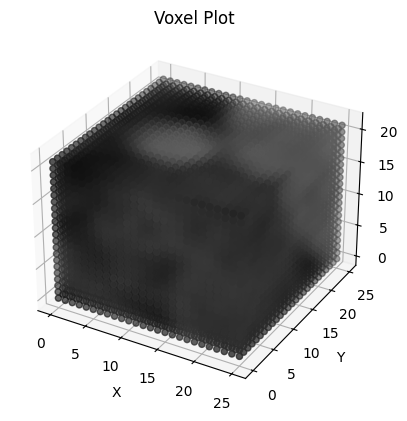

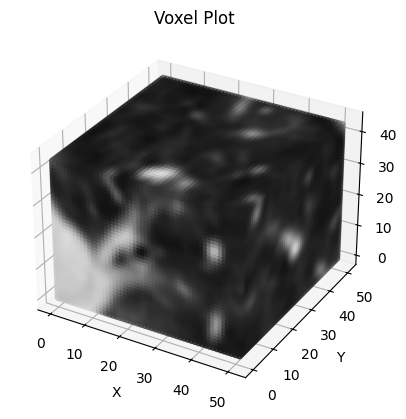

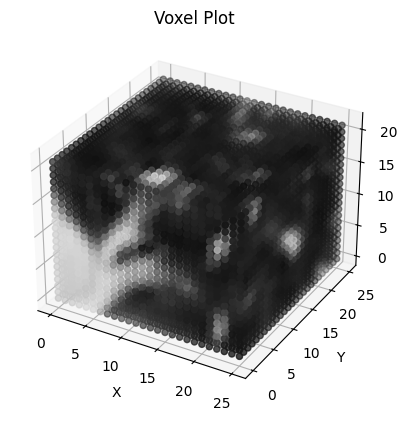

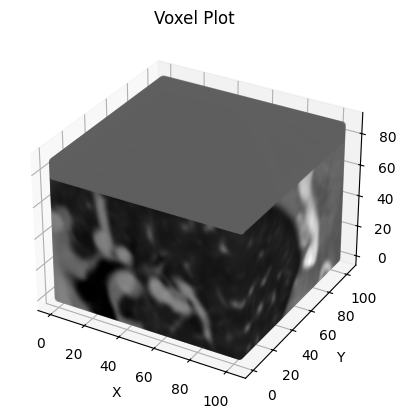

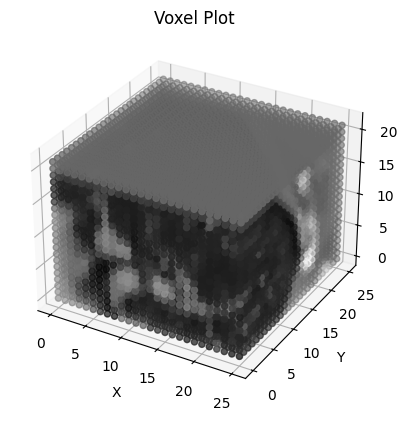

In [19]:
# Visualize all levels.
voxel_plot(base_level)

voxel_plot(level_0) 
voxel_plot(level0_post)

voxel_plot(level_1)
voxel_plot(level1_post)

In [26]:
from tqdm import tqdm
import glob

# Preprocess entire pyramid dataset. 
data_dir = 'data/filtered_subvolumes/ct_train'
level0_in_dir = os.path.join(data_dir, 'level_0_original')
level1_in_dir = os.path.join(data_dir, 'level_1_original')
level0_out_dir = os.path.join(data_dir, 'level_0')
level1_out_dir = os.path.join(data_dir, 'level_1')

dim_maxes = np.zeros(3, dtype=int)

# First process level 0.
for file in tqdm(glob.glob(os.path.join(level0_in_dir, '*.npy'))):
    
    # Load the volume. 
    volume = np.load(file)
    
    # Convert to tensor and add batch dimension.
    volume = torch.tensor(volume).float().unsqueeze(0)
    
    # Apply convolution.
    volume = level0_conv(volume)
    
    # Remove batch dimension and convert to numpy.
    volume = volume.squeeze().detach().numpy()
    
    # Update maxes with new volume shape.
    dim_maxes = np.maximum(dim_maxes, volume.shape)
    
    # Save the volume.
    np.save(os.path.join(level0_out_dir, os.path.basename(file)), volume)
    
# Now process level 1.
for file in tqdm(glob.glob(os.path.join(level1_in_dir, '*.npy'))):
    
    # Load the volume. 
    try: 
        volume = np.load(file)
        
        # Convert to tensor and add batch dimension.
        volume = torch.tensor(volume).float().unsqueeze(0)
        
        # Apply convolution.
        volume = level1_conv(volume)
        
        # Remove batch dimension and convert to numpy.
        volume = volume.squeeze().detach().numpy()

    except: 
        
        # Get basename of file. 
        basename = os.path.basename(file).split('.npy')[0]
        
        # Load original volume. 
        # Load base level. 
        original = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(parent_dir, basename + '.nii.gz')))

        # Flip axes to match numpy order.
        base_level = np.transpose(base_level, (1, 2, 0))
        
        volume = np.zeros(original.shape)
            
    # Update maxes with new volume shape.
    dim_maxes = np.maximum(dim_maxes, volume.shape)
            
    # Save the volume.
    np.save(os.path.join(level1_out_dir, os.path.basename(file)), volume)
    
print('Max dimensions:', dim_maxes)

  0%|          | 0/54 [00:00<?, ?it/s]

100%|██████████| 54/54 [00:13<00:00,  4.00it/s]

Max dimensions: [216 216 203]
